In [1]:
import numpy as np
import pandas as pd
from typing import List, Tuple, Union, Callable, Type
import warnings
from __future__ import annotations
from abc import ABC
from matplotlib import pyplot as plt
from tqdm import tqdm
#suppress warnings
warnings.filterwarnings('ignore')

In [2]:
def confusion_matrix(y_hat: np.array, y: np.array) -> np.array:
    num_class = len(np.unique(y))
    matrix = np.zeros((num_class, num_class))
    for y_true, y_hat in zip(y, y_hat):
        matrix[y_hat][y_true] += 1
    return matrix
    

def recall(y_hat: np.array, y: np.array) -> np.array:
    matrix = confusion_matrix(y_hat, y)
    n = len(matrix)
    recall = np.zeros(n)
    for i in range(n):
        recall[i] = matrix[i][i]/np.sum(matrix[:, i])
    return recall

def precision(y_hat: np.array, y: np.array) -> np.array:
    matrix = confusion_matrix(y_hat, y)
    n = len(matrix)
    precision = np.zeros(n)
    for i in range(n):
        precision[i] = matrix[i][i]/np.sum(matrix[i, :])
    return precision
    
def f_score(y_hat: np.array, y: np.array) -> np.array:
    r = recall(y_hat, y)
    p = precision(y_hat, y)
    f_score = 2*p*r/(p + r)
    return f_score

def one_hot_encoding(y: np.array) -> np.array:
    n = len(np.unique(y))
    m = len(y)
    zeros = np.zeros((m, n))
    for zero, i in zip(zeros, y):
        zero[i] = 1
    return zeros.transpose()

def proba_to_class(y_hat: np.array) -> np.array:
    classes = np.argmax(y_hat, axis = 0)
    return classes

In [3]:
np.linspace(0,1, 4)[1:-1]

array([0.33333333, 0.66666667])

In [4]:
def sigmoid(x: Union[int, np.array]) -> Union[int, np.array]:
    return np.exp(x)/(1 + np.exp(x))
        
def linear(x: Union[int, np.array]) -> Union[int, np.array]:
    return x

def softmax(x: Union[int, np.array]) -> Union[int, np.array]:
    return np.divide(np.exp(x), np.sum(np.exp(x), axis = 0))

In [5]:
class Loss(ABC):
    
    def __init__(self) -> None:
        pass
    
    def loss(self, y_hat: np.array, y: np.array) -> np.array:
        pass

class MSE(Loss):
    
    def __init__(self) -> None:
        super().__init__()
        
    def loss(self, y_hat: np.array, y: np.array) -> np.array:
        return np.mean(np.square(y-y_hat))
    
class Cross_entropy(Loss):
    
    def __init__(self) -> None:
        super().__init__()
        
    def loss(self, y_hat: np.array, y: np.array) -> np.array:
        epsilon = 1e-9
        return -np.mean(np.multiply(y, np.log(y_hat + epsilon)), axis = 1)
    

In [6]:
def dsigmoid(x: Union[int, np.array]) -> Union[int, np.array]:
    return sigmoid(x)*sigmoid(-x)

def dlinear(x: Union[int, np.array]) -> Union[int, np.array]:
    return np.ones(x.shape)



In [7]:
class Optimizer(ABC):
    
    def __init__(self, **kwargs: float) -> None:
        pass
        
    def fit_optimizer(self, w_opt: np.array,
                      b_opt: np.array, error_w: np.array,
                      error_b: np.array) -> Tuple[np.array]:
        pass

class Momentum(Optimizer):
    
    def __init__(self, lambd = 0.9) -> None:
        self.lambd = lambd
        
    def fit_optimizer(self, opt_w: np.array, 
                      opt_b: np.array, error_w: np.array,
                      error_b: np.array) -> Tuple[np.array]:
        opt_w = error_w + self.lambd * opt_w
        opt_b = error_b + self.lambd * opt_b
        
        update_w = opt_w
        update_b = opt_b
        
        return (opt_w, opt_b, update_w, update_b)
    

class RMSProp(Optimizer):
    
    def __init__(self, beta = 0.9) -> None:
        self.beta = beta
        
    def fit_optimizer(self, opt_w: np.array, 
                      opt_b: np.array, error_w: np.array,
                      error_b: np.array) -> Tuple[np.array]:
        opt_w = self.beta*opt_w + (1 - self.beta) * np.square(error_w)
        opt_b = self.beta*opt_b + (1 - self.beta) * np.square(error_b)
        
        update_w = np.divide(error_w, np.sqrt(opt_w))
        update_b = np.divide(error_b, np.sqrt(opt_b))
        
        return (opt_w, opt_b, update_w, update_b)
    

In [8]:
class Model(ABC):
    
    def __init__(self):
        self.weights = []
        self.biases = []
        self.best_weights = []
        self.best_biases = []
        self.best_loss = None
        self.activation_functions = []
        self.n = None
        self.optimizer = None
        self.loss = None
        self.num_layers = None
        self.metrics = {}
    
    def Input(self, shape: Tuple = (None, None)) -> int:
        pass
    
    def Output(self, shape: Tuple = (None, None)) -> int:
        pass
    
    def fit(self, X: np.array, y: np.array) -> Model:
        return self
    
    def add(self, nodes: int, activation_function: Callable[[Union[int, np.array]], Union[int, np.array]],
            weight: np.array) -> None:
        pass
    
    def complie(self, optimzer: Type[Optimizer]) -> None:
        pass
    
    def predict(self, x: np.array) -> np.array:
        pass
    
    def initialize(self) -> None:
        pass

In [294]:
class MLP(Model):
    
    def __init__(self) -> None:
        super().__init__()
        
    def Input(self, shape: Tuple = (None, None)) -> int:
        self.n = shape[1]
        
    def Output(self, shape: Tuple = (None, None)) -> int:
        pass
    
    def fit(self, X: np.array, y: np.array, eta: float, batch_size: int = 1, epochs: int = 1, verbose: int = 1) -> MLP:
        
        opt_b = [np.zeros(bias.shape) for bias in self.biases]
        opt_w = [np.zeros(weight.shape) for weight in self.weights]
        
        y_hat = self.predict(X) 
        self.best_loss = np.mean(self.loss().loss(y_hat, y))
        
        for epoch in range(epochs):
            concat = np.concatenate([X.transpose(), y.transpose()], axis = 1)
            np.random.shuffle(concat)
            X_shuffle = concat[:, :X.shape[0]].transpose()
            y_shuffle = np.squeeze(concat[:, X.shape[0]:]).transpose()
#             df = pd.DataFrame(X_shuffle.transpose())
#             dfy = pd.DataFrame(y_shuffle.transpose()).astype('int')
#           return X_shuffle, y_shuffle
            
            batches_X = [np.array(X_shuffle[:, i: i + batch_size]) for i in range(0, len(X[0]), batch_size)]
            batches_y = [y_shuffle[:, i: i + batch_size] for i in range(0, len(y), batch_size)]
            for batch_X, batch_y in zip(batches_X, batches_y):
                
                n = len(batch_X[0])
                error_b, error_w = self.backprop(batch_X, batch_y)                    
                
                for i in range(len(self.weights)):
                    
                    if self.optimizer is not None:
                        opt_w[i], opt_b[i], update_w, update_b = self.optimizer.fit_optimizer(
                            opt_w[i], opt_b[i], error_w[i], error_b[i])
                        
                    else:
                        update_w = error_w[i]
                        update_b = error_b[i]
                    
                    self.weights[i] -= eta*update_w/n
                    self.biases[i] -= eta*update_b/n
                    w = 'w' + str(i)
                    b = 'b' + str(i)
                    if w not in self.metrics and b not in self.metrics:
                        self.metrics[w] = [np.linalg.norm(self.weights[i])]
                        self.metrics[b] = [np.linalg.norm(self.biases[i])]
                    else:
                        self.metrics[w].append(np.linalg.norm(self.weights[i]))
                        self.metrics[b].append(np.linalg.norm(self.biases[i]))
                
            y_hat = self.predict(X)
            loss_hat = np.mean(self.loss().loss(y_hat, y))
            if verbose == 1 and epoch % int(max(1, epochs//10)) == 0:
                print(f'{type(self.loss()).__name__}: {loss_hat}')
            if loss_hat < self.best_loss:
                self.best_loss = loss_hat
                self.best_weights = self.weights
                self.best_biases = self.biases
                        
                        
                
    def backprop(self, X: np.array, y: np.array) -> List[np.array]:
        error_b = [np.zeros(bias.shape) for bias in self.biases]
        error_w = [np.zeros(weight.shape) for weight in self.weights]
        
        activation = X
        activations = [X]
        zs = []
        
        for weight, fun, bias in zip(self.weights, self.activation_functions, self.biases):
            z = np.dot(weight, activation) + bias.reshape(-1,1)
            zs.append(z)
            activation = fun(z)
            activations.append(activation)
        
        
        error = activations[-1] - y
        
        error_b[-1] = np.dot(error, np.ones(error.shape[1]).transpose())
        error_w[-1] = np.dot(error, activations[-2].transpose())
        
        for l in range(2, self.num_layers):
            z = zs[-l]
            dz = dsigmoid(z)
            error = np.multiply(np.dot(self.weights[-l+1].transpose(), error), dz)
            error_b[-l] = np.dot(error, np.ones(error.shape[1]).transpose())
            error_w[-l] = np.dot(error, activations[-l-1].transpose())
            
        return error_b, error_w
            
    def add(self, nodes: int, activation_function: Callable[[Union[int, np.array]], Union[int, np.array]],
            weight: np.array = None, bias: np.array = None) -> None:
        
        if weight is None and bias is None:
            weight, bias  = self.initialize(nodes)
            
        n_w, m_w = weight.shape
        
        weight = weight.transpose()
        
        self.weights.append(weight)
        self.biases.append(bias)
        self.best_weights.append(weight)
        self.best_biases.append(bias)
        self.activation_functions.append(activation_function)
        self.n = nodes
        
    def complie(self, loss: Type[Loss] = None, optimizer: Type[Optimizer] = None) -> None:
        self.num_layers = len(self.weights) + 1
        self.optimizer = optimizer
        self.loss = loss
        
    
    def predict(self, x: np.array) -> np.array:
        for weight, fun, bias in zip(self.best_weights, self.activation_functions, self.best_biases):
            x = fun(np.dot(weight, x) + bias.reshape(-1,1))
        return x     
    
    
    def initialize(self, m: int) -> None:
        weight = np.random.uniform(0, 1, size = (self.n, m))
        bias = np.random.uniform(0, 1, size = (m))
        return weight, bias

In [295]:
rings3_regular_test = pd.read_csv('mio1/classification/rings3-regular-test.csv')
rings3_regular_train = pd.read_csv('mio1/classification/rings3-regular-training.csv')
easy_test = pd.read_csv('mio1/classification/easy-test.csv')
easy_train = pd.read_csv('mio1/classification/easy-training.csv')
xor3_test = pd.read_csv('mio1/classification/xor3-test.csv')
xor3_train = pd.read_csv('mio1/classification/xor3-training.csv')

In [13]:
data_train = easy_train
data_test = easy_test

X_train = np.array(data_train[['x', 'y']])
y_train = np.array(data_train['c'])

X_test = np.array(data_test[['x', 'y']])
y_test = np.array([data_test['c']])
y_test = y_test.astype('int32')

In [252]:
mlp = MLP()

mlp.Input(shape = (None, 2))
mlp.add(20, sigmoid)
mlp.add(40, sigmoid)
mlp.add(2, softmax)
mlp.complie(loss = Cross_entropy)
mlp.fit(X_train.transpose(), y_train, eta = 0.003, batch_size= 128, epochs=1000)

y_hat_train = mlp.predict(X_train.transpose())
y_hat_test = mlp.predict(X_test.transpose())
y_hat_test = (y_hat_test[0] > 0.5).astype('int32')

print(f'Train Cross_entoropy: {Cross_entropy().loss(y_hat_train, y_train)}')
print(f'Test Cross_entopopy: {Cross_entropy().loss(y_hat_test, y_test)}')

print(f'Confusion matrix \n{confusion_matrix(y_hat_test, y_test[0])}')
print(f'Test F-score {f_score(y_hat_test, y_test[0])}')

plt.figure(figsize=(12, 8))
plt.scatter(easy_test['x'], easy_test['y'], c = data_test['c'])
plt.show()
plt.figure(figsize=(12, 8))
plt.scatter(easy_test['x'], easy_test['y'], c = y_hat_test)
plt.show()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [256]:
data_train = xor3_train
data_test = xor3_test

X_train = np.array(data_train[['x', 'y']])
y_train = np.array(data_train['c'])
y_train = y_train.astype('int32')
y_train_one = one_hot_encoding(y_train)

X_test = np.array(data_test[['x', 'y']])
y_test = np.array([data_test['c']])
y_test = y_test.astype('int32')
y_test_one = one_hot_encoding(y_test)

Cross_entropy: 0.40630591314121023
Cross_entropy: 0.26964470060765766
Cross_entropy: 0.25898245043888496
Cross_entropy: 0.25728256121162685
Cross_entropy: 0.2445056863888619
Cross_entropy: 0.24617092286034126
Cross_entropy: 0.21207016575805432
Cross_entropy: 0.16825228179752227
Cross_entropy: 0.1497263936633823
Cross_entropy: 0.14007598342985556
Train Cross_entoropy: [1.21709679 0.16644933]
Test Cross_entopopy: [0.98793894 0.19200542]
Confusion matrix 
[[264.  34.]
 [ 30. 172.]]
Test F-score 0.8675145733969263


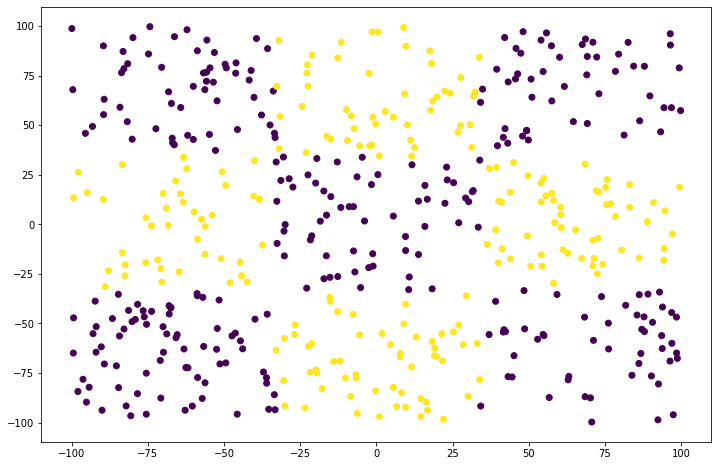

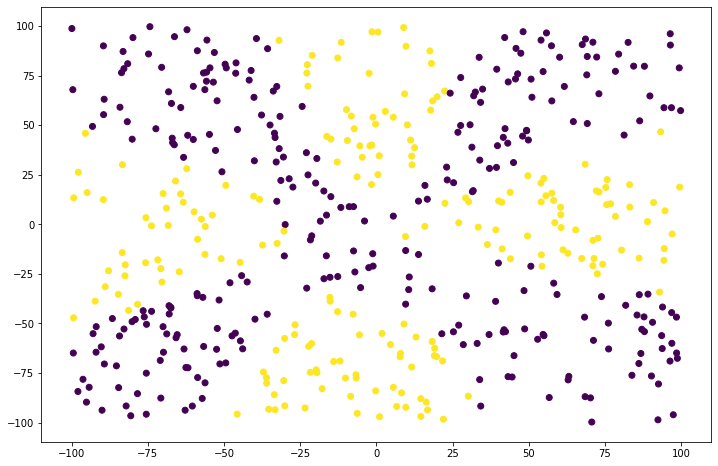

In [267]:
mlp = MLP()

mlp.Input(shape = (None, 2))
mlp.add(20, sigmoid)
mlp.add(140, sigmoid)
mlp.add(2, softmax)
mlp.complie(loss = Cross_entropy, optimizer=Momentum(0.99))
mlp.fit(X_train.transpose(), y_train_one, eta = 0.001, batch_size= 128 , epochs=10000)

y_hat_train = mlp.predict(X_train.transpose())
y_hat_test = mlp.predict(X_test.transpose())
y_hat_train_class = proba_to_class(y_hat_train)
y_hat_test_class = proba_to_class(y_hat_test)


print(f'Train Cross_entoropy: {Cross_entropy().loss(y_hat_train, y_train)}')
print(f'Test Cross_entopopy: {Cross_entropy().loss(y_hat_test, y_test)}')

print(f'Confusion matrix \n{confusion_matrix(y_hat_test_class, y_test[0])}')
print(f'Test F-score {np.mean(f_score(y_hat_test_class, y_test[0]))}')

plt.figure(figsize=(12, 8))
plt.scatter(xor3_test['x'], xor3_test['y'], c = xor3_test['c'])
plt.show()
plt.figure(figsize=(12, 8))
plt.scatter(xor3_test['x'], xor3_test['y'], c = y_hat_test_class)
plt.show()

In [268]:
data_train = rings3_regular_train
data_test = rings3_regular_test

X_train = np.array(data_train[['x', 'y']])
y_train = np.array(data_train['c'])
y_train = y_train.astype('int32')
y_train_one = one_hot_encoding(y_train)

X_test = np.array(data_test[['x', 'y']])
y_test = np.array([data_test['c']])
y_test = y_test.astype('int32')
y_test_one = one_hot_encoding(y_test)

In [297]:
mlp = MLP()

mlp.Input(shape = (None, 2))
mlp.add(80, sigmoid)
mlp.add(140, sigmoid)
mlp.add(3, softmax)
mlp.complie(loss = Cross_entropy, optimizer=Momentum(0.9))
X, y = mlp.fit(X_train.transpose(), y_train_one, eta = 0.002, batch_size= 128, epochs=10000)

y_hat_train = mlp.predict(X_train.transpose())
y_hat_test = mlp.predict(X_test.transpose())
y_hat_train_class = proba_to_class(y_hat_train)
y_hat_test_class = proba_to_class(y_hat_test)


print(f'Train Cross_entoropy: {Cross_entropy().loss(y_hat_train, y_train)}')
print(f'Test Cross_entopopy: {Cross_entropy().loss(y_hat_test, y_test)}')

print(f'Confusion matrix \n{confusion_matrix(y_hat_test_class, y_test[0])}')
print(f'Test F-score {np.mean(f_score(y_hat_test_class, y_test[0]))}')


# plt.figure(figsize=(12, 8))
# plt.scatter(rings3_regular_train['x'], rings3_regular_train['y'], c = rings3_regular_train['c'])
# plt.show()
# plt.figure(figsize=(12, 8))
# plt.scatter(rings3_regular_train['x'], rings3_regular_train['y'], c = y_hat_train_class)
# plt.show()


plt.figure(figsize=(12, 8))
plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = rings3_regular_test['c'])
plt.show()
plt.figure(figsize=(12, 8))
plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = y_hat_test_class)
plt.show()

Cross_entropy: 1.3585351906890069
Cross_entropy: 0.348694893807106
Cross_entropy: 0.34135264925855174
Cross_entropy: 0.3369355807983323
Cross_entropy: 0.33196411950966953
Cross_entropy: 0.3269280571396882
Cross_entropy: 0.32327558110313587
Cross_entropy: 0.318661688903393
Cross_entropy: 0.31508330079350566
Cross_entropy: 0.3104428095848876


TypeError: cannot unpack non-iterable NoneType object

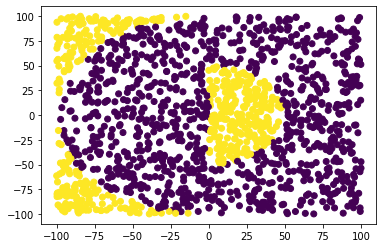

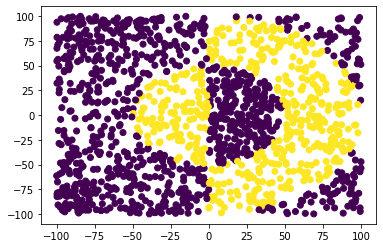

In [293]:
df = pd.DataFrame(X.transpose())
dfy = pd.DataFrame(y.transpose())
plt.scatter(df[0], df[1], c = dfy[0])
plt.show()
plt.scatter(df[0], df[1], c = dfy[1])
plt.show()